In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, Predictive, TraceMeanField_ELBO
from pyro.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D



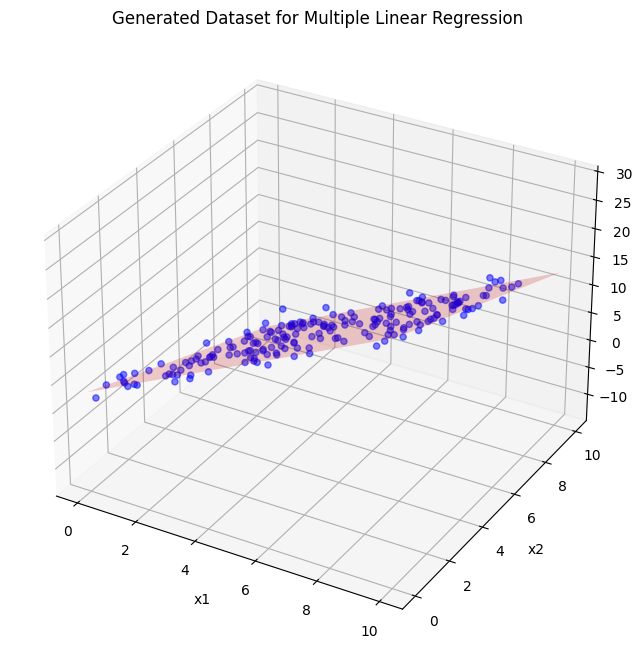

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate data
n_samples = 200

# Generate two input features
x1 = np.random.uniform(0, 10, n_samples)
x2 = np.random.uniform(0, 10, n_samples)

# True relationship parameters
true_coef1 = 2.5
true_coef2 = -1.5
true_intercept = 3.0

# Generate target variable with noise
noise = np.random.normal(0, 1, n_samples)
y = true_coef1 * x1 + true_coef2 * x2 + true_intercept + noise

# Combine into dataset
X_np = np.column_stack([x1, x2])
y_np = y.reshape(-1, 1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
scatter = ax.scatter(X_np[:, 0], X_np[:, 1], y_np, c='blue', alpha=0.5, label='Data points')

# Create a wireframe of the true relationship
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 20), np.linspace(0, 10, 20))
y_grid = true_coef1 * x1_grid + true_coef2 * x2_grid + true_intercept

# Plot the true relationship plane
surface = ax.plot_surface(x1_grid, x2_grid, y_grid, alpha=0.2, color='red')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('Generated Dataset for Multiple Linear Regression')
plt.show()

In [3]:
def model(X, Y):
    slope = pyro.sample('slope', dist.Normal(torch.zeros(X.shape[-1]), torch.ones(X.shape[-1])).to_event(1))
    intercept = pyro.sample('intercept', dist.Normal(0.0, 1.0))
    sigma = pyro.sample('sigma', dist.LogNormal(0.0, 0.5))
    mean = torch.matmul(X, slope) + intercept
    with pyro.plate('data', X.shape[0]):
        obs = pyro.sample('obs', dist.Normal(mean.reshape(-1,1), sigma).to_event(1), obs=Y)

def guide(X, Y):
    slope_loc = pyro.param('slope_loc', torch.zeros(X.shape[-1]))
    slope_scale = pyro.param('slope_scale', torch.ones(X.shape[-1]), constraint=dist.constraints.positive)

    intercept_loc = pyro.param('intercept_loc', torch.tensor(0.0))
    intercept_scale = pyro.param('intercept_scale', torch.tensor(1.0), constraint=dist.constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.0), constraint=dist.constraints.positive)

    slope = pyro.sample('slope', dist.Normal(slope_loc, slope_scale).to_event(1))
    intercept = pyro.sample('intercept', dist.Normal(intercept_loc, intercept_scale))
    sigma = pyro.sample('sigma', dist.LogNormal(sigma_loc, torch.tensor(1.0)))


Step 0 : Loss = 2538.294189453125
Step 100 : Loss = 4567.77978515625
Step 200 : Loss = 2734.5322265625
Step 300 : Loss = 8456.01953125
Step 400 : Loss = 611.9323120117188
Step 500 : Loss = 691.1240234375
Step 600 : Loss = 783.4583129882812
Step 700 : Loss = 801.630859375
Step 800 : Loss = 831.5606079101562
Step 900 : Loss = 3025.60009765625
Step 1000 : Loss = 956.2199096679688
Step 1100 : Loss = 711.8984985351562
Step 1200 : Loss = 872.4927368164062
Step 1300 : Loss = 1223.8033447265625
Step 1400 : Loss = 1053.2763671875
Step 1500 : Loss = 1167.1419677734375
Step 1600 : Loss = 892.17919921875
Step 1700 : Loss = 1031.140869140625
Step 1800 : Loss = 1054.418212890625
Step 1900 : Loss = 1139.4552001953125
Step 2000 : Loss = 722.857666015625
Step 2100 : Loss = 949.5437622070312
Step 2200 : Loss = 978.7288208007812
Step 2300 : Loss = 935.0582885742188
Step 2400 : Loss = 1148.808349609375
Step 2500 : Loss = 739.2638549804688
Step 2600 : Loss = 1003.3017578125
Step 2700 : Loss = 1107.64831542

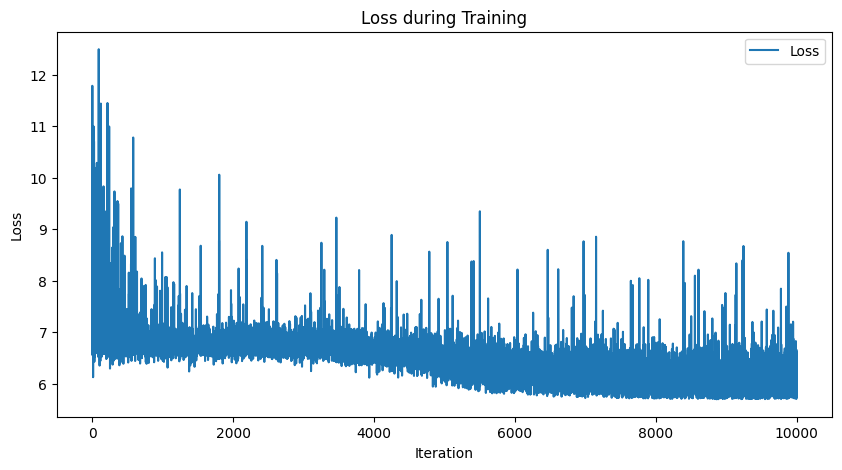

In [4]:
optim = Adam({"lr": 0.01})

svi = SVI(model, guide, optim, loss=TraceMeanField_ELBO())
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
num_iterations = 10000
losses = []
slope = torch.zeros(2,2,100)
intercept = torch.zeros(1,2,100)
for step in range(num_iterations):
    loss = svi.step(X, y)
    losses.append(np.log(loss))
    if step % 100 == 0:
        print(f"Step {step} : Loss = {loss}")
        slope[:,0,int(step/100)] = pyro.param('slope_loc').detach()
        slope[:,1,int(step/100)] = pyro.param('slope_scale').detach()
        intercept[:,0,int(step/100)] = pyro.param('intercept_loc').item()
        intercept[:,1,int(step/100)] = pyro.param('intercept_scale').item()

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()
plt.show()

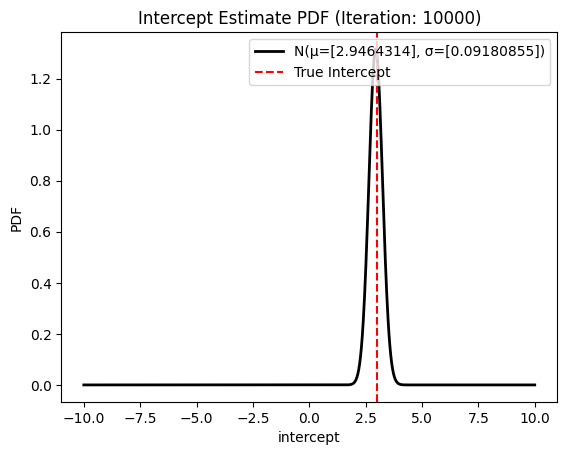

In [15]:
from matplotlib.animation import FuncAnimation
# Set up the figure and axis
fig, ax = plt.subplots()
# Setting up the title, labels, and vertical line for end of training data
ax.set_title('Estimation of intercept')
ax.set_xlabel('intercept')
ax.set_ylabel('PDF')
ax.axvline(3, label='True Intercept', color='red', linestyle='--')
ax.legend()
intercept_np = intercept.detach().numpy()
# Function to update the plot for each frame
def update(frame):
    # Clear the current axis
    ax.clear()
    mean = intercept_np[:,0,frame]
    std = intercept_np[:,1,frame]
    x = np.linspace(-10,10, 1000)
    y = (1 / (np.sqrt(2 * np.pi*std))) * np.exp(-0.5 * ((x - mean) / np.sqrt(std))**2)

    # Plot the predicted and true values
    ax.plot(x, y, 'k-', lw=2, label=f'N(μ={mean}, σ={std})')
    ax.axvline(3, label='True Intercept', color='red', linestyle='--')

    # Update the title and labels
    ax.set_title(f'Intercept Estimate PDF (Iteration: {100*(frame+1)})')
    ax.set_xlabel('intercept')
    ax.set_ylabel('PDF')
    ax.legend(loc='upper right')
    return ax,
# Create animation
anim = FuncAnimation(fig, update, frames=intercept.shape[2])

# Save the animation as a GIF
anim.save('Intercept_PDF.gif', writer='pillow', fps=10)

plt.show()

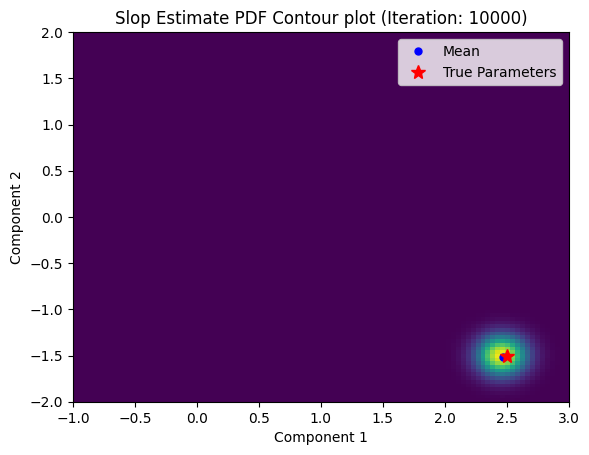

In [33]:
# Set up the figure and axis
fig, ax = plt.subplots()
# Setting up the title, labels, and vertical line for end of training data
ax.set_title('Estimation of intercept')
ax.set_xlabel('intercept')
ax.set_ylabel('PDF')
ax.axvline(3, label='True Intercept', color='red', linestyle='--')
ax.legend()
slope_np = slope.detach().numpy()
# Function to update the plot for each frame
def update(frame):
    # Clear the current axis
    ax.clear()
    mean = slope_np[:,0,frame]
    std = slope_np[:,1,frame]
    x = np.linspace(-1,3, 100)
    y = np.linspace(-2,2, 100)
    X, Y = np.meshgrid(x, y)
    
    # Calculate PDF values for all grid points
    Z = np.zeros_like(X)
    for i in range(100):
        for j in range(100):
            # Simplified PDF calculation for diagonal covariance
            factor = 2*np.pi*np.sqrt(std[0]*std[1])
            exp1 = ((X[i,j] - mean[0])**2/std[0])
            exp2 = ((Y[i,j] - mean[1])**2/std[1])
            Z[i,j] =np.exp(-0.5 * (exp1 + exp2))/factor

    # Plot the predicted and true values
    # ax.contour(X, Y, Z, levels=100, cmap='viridis')
    im = ax.imshow(Z, 
                    extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower',
                    cmap='viridis',
                    aspect='auto')
    ax.plot(mean[0], mean[1], 'bo', markersize=5, label='Mean')
    ax.plot(2.5, -1.5, 'r*', markersize=10, label='True Parameters')

    # Update the title and labels
    ax.set_title(f'Slop Estimate PDF Contour plot (Iteration: {100*(frame+1)})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(loc='upper right')
    return ax,
# Create animation
anim = FuncAnimation(fig, update, frames=100)

# Save the animation as a GIF
anim.save('Slope_PDF.gif', writer='pillow', fps=10)

plt.show()

In [5]:
for name, value in pyro.get_param_store().items():
    print(name, value.detach().numpy())

slope_loc [ 2.5106113 -1.5039577]
slope_scale [0.01936521 0.02244907]
intercept_loc 2.9704776
intercept_scale 0.09310798
sigma_loc 1.0423464
